# ClinicalBERT

[ClinicalBERT](https://github.com/EmilyAlsentzer/clinicalBERT) is pre-trained on clinical notes and electronic health records (EHRs). It focuses on capturing language patterns and clinical terminologies commonly found in patient records.

> BioBERT significantly outperforms other state of the art BERTs on the following three representative biomedical text mining tasks:
* biomedical named entity recognition (0.62% F1 score improvement)
* biomedical relation extraction (2.80% F1 score improvement) and
* biomedical question answering (12.24% MRR improvement).

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 22.8 MB/s eta 0:00:00


In [ ]:
!pip install torch

In [ ]:
!pip install transformers --upgrade

# Fine-Tuning

## Load in the data

In [ ]:
import pandas as pd

df = pd.read_csv('/content/sentences_and_tags.csv')

df.head()

,Unnamed: 0,Sentences,Tag,Name Tag
0,sentece 0,I first noticed my tinnitus after attending a ...,1,Main
1,sentece 1,I was not wearing ear protection at the time.,2,Note
2,sentece 2,I've seen an audiologist who recommended heari...,1,Main
3,sentece 3,"I've been using them regularly, but the tinnit...",2,Note
4,sentece 4,It's frustrating because it's affecting my sleep.,3,Emotion


<Axes: ylabel='Name Tag'>

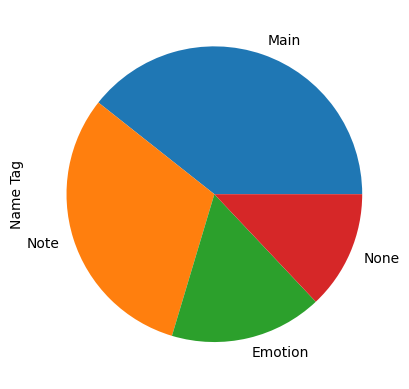

In [ ]:
df['Name Tag'].value_counts().plot(kind='pie')

In [ ]:
import transformers
import torch
from transformers import AutoTokenizer
from torch.nn import CrossEntropyLoss

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [ ]:
from transformers import BertConfig, BertForSequenceClassification

config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True, num_labels=4)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)
loss_fn = torch.nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Method to Tune in Batches

In [ ]:
from torch.utils.data import Dataset, DataLoader

import torch
from torch.utils.data import Dataset, DataLoader

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['Sentences']
        label = self.data.iloc[idx]['Tag']

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
            return_token_type_ids=False,
            return_attention_mask=True,
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# Define your dataset and dataloader
dataset = CustomDataset(dataframe=df, tokenizer=tokenizer, max_length=128)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
count = 0
for batch in data_loader:
  print(batch['labels'].view(-1, 1).shape)

  count +=1
  if count == 1:
    break

torch.Size([8, 1])


### Gradient Clipping

* **Gradients** are used to determine how much each parameter should be adjusted to minimize the loss

* Updating params in the opposite direction of gradients happens through optimizers. In our case we are using Adam

In [ ]:
#Gradient Clipping: helps prevent exploding gradients
clip_grad_norm_ = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

Attempt to prevent overfitting 1:


1.   Added L2 (weight decay) Regularization
>* Penalty to loss based on magnitude of weights
2. Reduced Batch Size
>* Made Learning Rate Smaller
4. Reduced epochs (20->16)
5. Included Gradient Clipping



### With NOTE tag

In [ ]:
from torch.utils.data import DataLoader

batch_size = 8
max_grad_norm = 1.0 # common default value
# Create a DataLoader to handle mini-batches
for epoch in range(16):
    total_loss = 0.0
    for batch in data_loader:
        optimizer.zero_grad()

        # Forward pass for the entire mini-batch
        inputs = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        outputs = model(inputs, attention_mask=attention_mask)

        # Calculate the loss for the mini-batch
        batch_loss = loss_fn(outputs.logits, batch["labels"])

        # Backward pass and optimization
        batch_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)

        optimizer.step()

        total_loss += batch_loss.item()

    average_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average loss: {average_loss}")


Epoch 1, Average loss: 1.2646715994234439
Epoch 2, Average loss: 1.006406580960309
Epoch 3, Average loss: 0.7040162770836441
Epoch 4, Average loss: 0.44277996928603564
Epoch 5, Average loss: 0.24724831073372452
Epoch 6, Average loss: 0.12125451966292328
Epoch 7, Average loss: 0.05409891254923962
Epoch 8, Average loss: 0.027909751912509953
Epoch 9, Average loss: 0.017593607703154837
Epoch 10, Average loss: 0.011897083320137527


KeyboardInterrupt: ignored

In [ ]:
model.save_pretrained('./MediMapBERT2')

In [ ]:
# @title MediMapBERT
# Define a function to get user input
def get_label(doc):
    tokens = tokenizer(doc, padding=True, truncation=True, return_tensors="pt")
    outputs = model(**tokens)
    logits = outputs.logits

    probabilities = torch.softmax(logits, dim=1)
    predicted_labels = torch.argmax(probabilities, dim=1)
    print(probabilities)

    return df['Name Tag'].where(df['Tag'] == int(predicted_labels[0])).dropna().unique()

# Collect user input
Sentence = 'My tinnitus started when I was 12 years old' # @param {type:"string"}
label = get_label(Sentence)

# Display the collected information
print(f"[{label[0]}] {Sentence}.")

tensor([[0.0035, 0.8762, 0.1151, 0.0051]], grad_fn=<SoftmaxBackward0>)
[Main] My tinnitus started when I was 12 years old.


In [ ]:
# @title MediMapBERT
# Define a function to get user input
def get_label(doc):
    tokens = tokenizer(doc, padding=True, truncation=True, return_tensors="pt")
    outputs = model(**tokens)
    logits = outputs.logits

    probabilities = torch.softmax(logits, dim=1)
    predicted_labels = torch.argmax(probabilities, dim=1)
    print(probabilities)

    return df['Name Tag'].where(df['Tag'] == int(predicted_labels[0])).dropna().unique()

# Collect user input
Sentence = 'hello world' # @param {type:"string"}
label = get_label(Sentence)

# Display the collected information
print(f"[{label[0]}] {Sentence}.")

tensor([[0.1611, 0.0246, 0.7953, 0.0190]], grad_fn=<SoftmaxBackward0>)
[Note] hello world.


## Overfitted on Note tag

In [ ]:
from torch.utils.data import DataLoader

batch_size = 16

# Create a DataLoader to handle mini-batches
for epoch in range(20):
    total_loss = 0.0
    for batch in data_loader:
        optimizer.zero_grad()

        # Forward pass for the entire mini-batch
        inputs = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        outputs = model(inputs, attention_mask=attention_mask)

        # Calculate the loss for the mini-batch
        batch_loss = loss_fn(outputs.logits, batch["labels"])

        # Backward pass and optimization
        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item()

    average_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average loss: {average_loss}")


Epoch 1, Average loss: 1.2815276639802116
Epoch 2, Average loss: 1.0743913395064217
Epoch 3, Average loss: 0.8775515939508166
Epoch 4, Average loss: 0.7097667157649994
Epoch 5, Average loss: 0.5481359596763339
Epoch 6, Average loss: 0.41892827089343754
Epoch 7, Average loss: 0.31544075693402973
Epoch 8, Average loss: 0.2232917467398303
Epoch 9, Average loss: 0.16841202016387666
Epoch 10, Average loss: 0.12105030460017067
Epoch 11, Average loss: 0.0949884078332356
Epoch 12, Average loss: 0.07673528497772557
Epoch 13, Average loss: 0.06588890190635409
Epoch 14, Average loss: 0.05707940139940807
Epoch 15, Average loss: 0.05209269680614982
Epoch 16, Average loss: 0.047185231266277175
Epoch 17, Average loss: 0.04382049518504313
Epoch 18, Average loss: 0.04031187295913696
Epoch 19, Average loss: 0.04786184177334819
Epoch 20, Average loss: 0.04478225151875189


In [ ]:
model.save_pretrained('./MediMapBERT')


In [ ]:
df['Sentences'][8]

'I saw an ENT specialist who prescribed a corticosteroid.'

In [ ]:
# @title MediMapBERT
# Define a function to get user input
def get_label(doc):
    tokens = tokenizer(doc, padding=True, truncation=True, return_tensors="pt")
    outputs = model(**tokens)
    logits = outputs.logits

    probabilities = torch.softmax(logits, dim=1)
    predicted_labels = torch.argmax(probabilities, dim=1)
    print(probabilities)

    return df['Name Tag'].where(df['Tag'] == int(predicted_labels[0])).dropna().unique()

# Collect user input
Sentence = 'ooga booga' # @param {type:"string"}
label = get_label(Sentence)

# Display the collected information
print(f"[{label[0]}] {Sentence}.")

tensor([[0.1024, 0.1103, 0.7607, 0.0266]], grad_fn=<SoftmaxBackward0>)
[Note] ooga booga.


In [ ]:
#new_document = "The stress from breaking my nose leading to my tinnitus has been affecting my mental health."
new_document = "I am so frustrated."
tokens = tokenizer(new_document, padding=True, truncation=True, return_tensors="pt")

#model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
outputs = model(**tokens)
logits = outputs.logits

probabilities = torch.softmax(logits, dim=1)
predicted_labels = torch.argmax(probabilities, dim=1)


# Print the generated labels
print(df['Name Tag'].where(df['Tag'] == int(predicted_labels[0])).dropna().unique())

['Note']


## Method to Tune Training on Single Examples/ Online Learning

In [ ]:
def custom_tokenize(text):
    # Tokenize the text using the specified tokenizer
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    return tokens

df['Tokenized'] = df['Sentences'].apply(custom_tokenize)


first_sentence_tokenized = df['Tokenized'][0]
print(first_sentence_tokenized)

In [ ]:
labels = torch.tensor(df['Tag'], dtype=torch.long)
print(labels.shape)

torch.Size([216])


In [ ]:
batch_size = 16
for epoch in range(20):
  total_loss = 0.0
  optimizer.zero_grad()

  for i, row in df.iterrows():
    # Forward pass
    outputs = model(row["Tokenized"]["input_ids"], attention_mask=row["Tokenized"]["attention_mask"])
    loss = loss_fn(outputs.logits, labels[i].view(-1))

    # Backward pass
    loss.backward()
    optimizer.step()

    total_loss += loss.item()  # Accumulate the loss for this batch

  average_loss = total_loss / len(df)
  print(f"Epoch {epoch + 1}, Average loss: {average_loss}")

In [ ]:
for epoch in range(20):
  total_loss = 0.0
  optimizer.zero_grad()
  for i, row in df.iterrows():
    # Forward pass
    outputs = model(row["Tokenized"]["input_ids"], attention_mask=row["Tokenized"]["attention_mask"])
    loss = loss_fn(outputs.logits, labels[i].view(-1))

    # Backward pass
    loss.backward()
    optimizer.step()

    total_loss += loss.item()  # Accumulate the loss for this batch

  average_loss = total_loss / len(df)
  print(f"Epoch {epoch + 1}, Average loss: {average_loss}")

Epoch 1, Average loss: 1.3072802856288575
Epoch 2, Average loss: 1.4977748977641265
Epoch 3, Average loss: 1.4848712453687634
Epoch 4, Average loss: 1.347557984844402
Epoch 5, Average loss: 1.3878188613388274
Epoch 6, Average loss: 1.4509746338482257
Epoch 7, Average loss: 1.3904243473101545
Epoch 8, Average loss: 1.340078492131498
Epoch 9, Average loss: 1.371604642658322
Epoch 10, Average loss: 1.3683943309717708
Epoch 11, Average loss: 1.4112837264935176
Epoch 12, Average loss: 1.3484735014262024
Epoch 13, Average loss: 1.4055931485361524


KeyboardInterrupt: ignored

In [ ]:
# Create one-hot encoded labels
labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=len(labels.unique()))
labels_one_hot[0]

tensor([0, 1, 0, 0])

In [ ]:
outputs.logits

tensor([[0.0675, 0.1436]], grad_fn=<AddmmBackward0>)

In [ ]:
labels[i].view(-1)

tensor([2])

In [ ]:
torch.argmax(outputs.logits, dim=1)

tensor([1])

In [ ]:
l = torch.tensor([0,1,2,3], dtype=torch.long)
l.shape, l.view(-1).shape

(torch.Size([4]), torch.Size([4]))

In [ ]:
labels.view(-1).shape

torch.Size([216])

In [ ]:
labels

tensor([1, 2, 1, 2, 3, 0, 1, 2, 1, 2, 0, 3, 1, 2, 1, 2, 0, 3, 1, 2, 1, 2, 3, 0,
        1, 2, 1, 2, 3, 0, 1, 2, 1, 2, 3, 0, 1, 2, 1, 2, 3, 0, 1, 2, 1, 2, 3, 0,
        1, 2, 1, 2, 3, 0, 1, 2, 1, 2, 3, 0, 1, 2, 1, 2, 3, 0, 1, 2, 1, 2, 3, 0,
        1, 2, 1, 2, 3, 0, 1, 2, 1, 2, 3, 0, 1, 2, 1, 2, 3, 0, 1, 2, 1, 2, 3, 1,
        2, 1, 2, 3, 3, 1, 2, 1, 2, 3, 1, 2, 1, 3, 1, 2, 1, 2, 3, 1, 2, 1, 2, 3,
        1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 2,
        1, 1, 2, 3, 0, 2, 1, 2, 1, 3, 0, 2, 1, 1, 3, 0, 2, 1, 1, 2, 3, 0, 2, 1,
        1, 2, 3, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 3, 0, 1, 1, 0, 2, 3, 0, 1,
        0, 0, 1, 1, 1, 1, 0, 3, 0, 1, 2, 1, 2, 2, 1, 2, 1, 2, 3, 2, 2, 1, 2, 0])

In [ ]:
all_logits.shape

torch.Size([216, 2])

# Fine-Tuning with a More even class distribution
* trade-off: less data

In [ ]:
import pandas as pd

df = pd.read_csv('/content/sentences_and_tags.csv')

df.head()

,Unnamed: 0,Sentences,Tag,Name Tag
0,sentece 0,I first noticed my tinnitus after attending a ...,1,Main
1,sentece 1,I was not wearing ear protection at the time.,2,Note
2,sentece 2,I've seen an audiologist who recommended heari...,1,Main
3,sentece 3,"I've been using them regularly, but the tinnit...",2,Note
4,sentece 4,It's frustrating because it's affecting my sleep.,3,Emotion


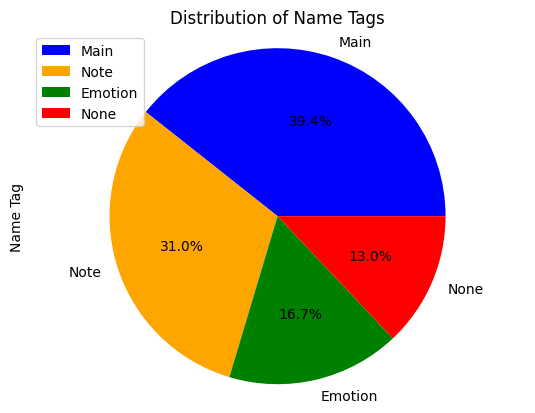

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define a dictionary that maps labels to colors
color_mapping = {'Main': 'blue', 'Note': 'orange', 'Emotion': 'green', 'None': 'red'}


# Create a pie chart with labels and custom colors
name_tag_counts = df['Name Tag'].value_counts()
name_tags = name_tag_counts.index
colors = [color_mapping[tag] for tag in name_tags]
name_tag_counts.plot(kind='pie', colors=colors, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Add a legend with labels
plt.legend(name_tags)

plt.title("Distribution of Name Tags")
plt.show()



In [ ]:
# Fraction of 'Note' and 'Main' class data to keep
fraction_to_keep = 0.4

# Filter rows for the 'Note' class, randomly sample a fraction of them, and combine with the non-'Note' class data
note_class_data = df[df['Name Tag'] == 'Note']
sampled_note_class_data = note_class_data.sample(frac=fraction_to_keep, random_state=17)

# Filter rows for the 'Main' class, randomly sample a fraction of them, and combine with the existing data (filtered_df)
main_class_data = df[df['Name Tag'] == 'Main']
sampled_main_class_data = main_class_data.sample(frac=fraction_to_keep, random_state=17)

# Combine the sampled 'Note' and 'Main' class data with the non-'Note' and non-'Main' class data
filtered_df = pd.concat([df[~df['Name Tag'].isin(['Note', 'Main'])], sampled_note_class_data, sampled_main_class_data])


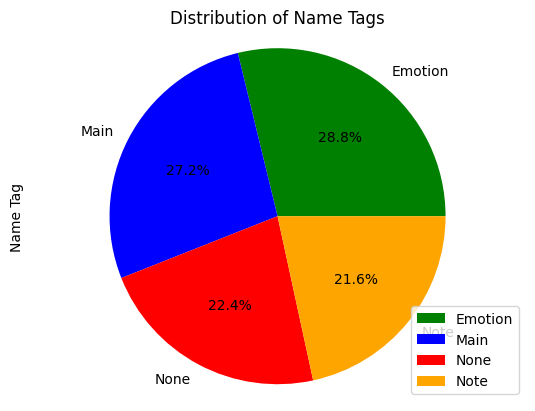

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define a dictionary that maps labels to colors
color_mapping = {'Main': 'blue', 'Note': 'orange', 'Emotion': 'green', 'None': 'red'}


# Create a pie chart with labels and custom colors
name_tag_counts = filtered_df['Name Tag'].value_counts()
name_tags = name_tag_counts.index
colors = [color_mapping[tag] for tag in name_tags]
name_tag_counts.plot(kind='pie', colors=colors, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Add a legend with labels
plt.legend(name_tags)

plt.title("Distribution of Name Tags")
plt.show()



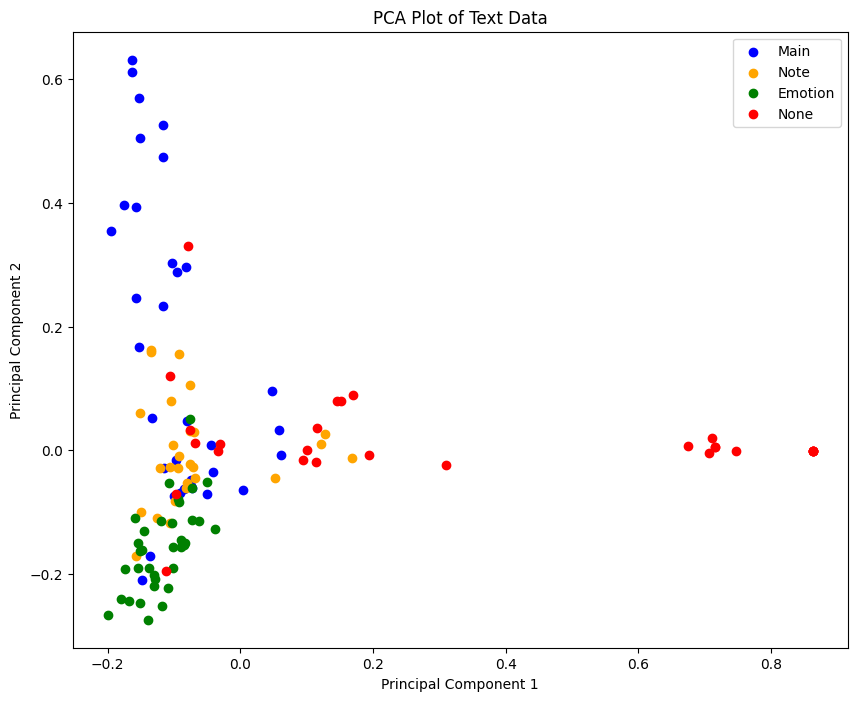

In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np

name_tags = filtered_df['Name Tag']
sentences = filtered_df['Sentences']

# Create a color mapping dictionary
color_mapping = {'Main': 'blue', 'Note': 'orange', 'Emotion': 'green', 'None': 'red'}

# Map 'Name Tag' values to colors
name_tag_colors = [color_mapping[tag] for tag in name_tags]

# TF-IDF Vectorization:
tfidf_vectorizer = TfidfVectorizer()
sentence_vectors = tfidf_vectorizer.fit_transform(sentences)

# Perform PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(sentence_vectors.toarray())

# Create the PCA plot with colors
plt.figure(figsize=(10, 8))
for tag, color in color_mapping.items():
    plt.scatter(reduced_features[name_tags == tag, 0], reduced_features[name_tags == tag, 1], label=tag, c=color)

plt.title("PCA Plot of Text Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


In [ ]:
import transformers
import torch
from transformers import AutoTokenizer
from torch.nn import CrossEntropyLoss

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [ ]:
from transformers import BertConfig, BertForSequenceClassification

config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True, num_labels=4)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)
loss_fn = torch.nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
len(filtered_df)

125

## Method to Tune in Batches

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['Sentences']
        label = self.data.iloc[idx]['Tag']

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
            return_token_type_ids=False,
            return_attention_mask=True,
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# Define your dataset and dataloader
dataset = CustomDataset(dataframe=filtered_df, tokenizer=tokenizer, max_length=128)
data_loader = DataLoader(dataset, batch_size=6, shuffle=True)

In [ ]:
count = 0
for batch in data_loader:
  print(batch['labels'].view(-1, 1).shape)

  count +=1
  if count == 1:
    break

torch.Size([6, 1])


### Gradient Clipping

* **Gradients** are used to determine how much each parameter should be adjusted to minimize the loss

* Updating params in the opposite direction of gradients happens through optimizers. In our case we are using Adam

In [ ]:
#Gradient Clipping: helps prevent exploding gradients
clip_grad_norm_ = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

In [ ]:
from torch.utils.data import DataLoader

batch_size = data_loader.batch_size
max_grad_norm = 1.0 # common default value
# Create a DataLoader to handle mini-batches
for epoch in range(10):
    total_loss = 0.0
    for batch in data_loader:
        optimizer.zero_grad()

        # Forward pass for the entire mini-batch
        inputs = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        outputs = model(inputs, attention_mask=attention_mask)

        # Calculate the loss for the mini-batch
        batch_loss = loss_fn(outputs.logits, batch["labels"])

        # Backward pass and optimization
        batch_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)

        optimizer.step()

        total_loss += batch_loss.item()

    average_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average loss: {average_loss}")


Epoch 1, Average loss: 1.3492182549976168
Epoch 2, Average loss: 1.0698503568058921
Epoch 3, Average loss: 0.8132715991565159
Epoch 4, Average loss: 0.5765355839615777
Epoch 5, Average loss: 0.3841814718076161
Epoch 6, Average loss: 0.2596068148102079
Epoch 7, Average loss: 0.16125424099820002
Epoch 8, Average loss: 0.10215499216601961
Epoch 9, Average loss: 0.055042874068021774
Epoch 10, Average loss: 0.029323391084160124


In [ ]:
# @title MediMapBERT
# Define a function to get user input
def get_label(doc):
    tokens = tokenizer(doc, padding=True, truncation=True, return_tensors="pt")
    outputs = model(**tokens)
    logits = outputs.logits

    probabilities = torch.softmax(logits, dim=1)
    predicted_labels = torch.argmax(probabilities, dim=1)
    print(probabilities)

    return df['Name Tag'].where(df['Tag'] == int(predicted_labels[0])).dropna().unique()

# Collect user input
Sentence = 'I am angry that he misdiagnosed me' # @param {type:"string"}
label = get_label(Sentence)

# Display the collected information
print(f"[{label[0]}] {Sentence}.")

tensor([[0.0879, 0.7837, 0.1137, 0.0147]], grad_fn=<SoftmaxBackward0>)
[Main] I am angry that he misdiagnosed me.


In [ ]:
model.save_pretrained('./MediMapBERT(balanced)')

# Grouping Classes
* Main, Note & Emotion, None

# Demo

In [ ]:
 dataset = [
    {
        "input_ids": encodings['input_ids'],
        "attention_mask": encodings['attention_mask'],
        "labels": labels,
    }
]

In [ ]:
# import torch
# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Create a dataset of sequence labeled documents
# This can be done by loading a pre-existing dataset or creating your own

input_labels = {
    '[Main]': 1,
    '[Note]': 2,
    '[Emotion]': 1,
    '[None]': 4
}

labeled_tensor = []
#labeled_data = "[Emotion] The stress from my injury and the resulting tinnitus has been taking a toll on my mental health. [Main] Tinnitus began after I underwent blood flow restriction therapy as part of my rehabilitation process. [Note] The stress of the therapy has made it challenging to manage the tinnitus. [Main] I consulted my physical therapist, who recommended stress reduction techniques to alleviate the tinnitus symptoms."
labeled_data = "[Emotion] The stress from my injury and the resulting tinnitus has been taking a toll on my mental health."
for w in labeled_data.split():
  try:
    if input_labels[w]:
      labeled_tensor.append(input_labels[w])
  except:
    continue
print(labeled_tensor)

[1]


In [ ]:
import transformers
import torch
from transformers import AutoTokenizer
from torch.nn import CrossEntropyLoss
from transformers import BertConfig, BertModel, BertForSequenceClassification, AutoModelForSequenceClassification


input_lables = {
    '[Main]' : 0,
    '[Note]' : 2,
    '[Emotion]' : 1,
    '[None]' : 4
                }

doc_labels = []
#labeled_data = "[Emotion] The stress from my injury and the resulting tinnitus has been taking a toll on my mental health. [Main] Tinnitus began after I underwent blood flow restriction therapy as part of my rehabilitation process."
doc1 = "[Emotion] The stress from my injury and the resulting tinnitus has been taking a toll on my mental health."
doc2 = "[Main] Tinnitus began after I underwent blood flow restriction therapy as part of my rehabilitation process."

doc_labels.append(input_lables[doc1.split()[0]])
doc_labels.append(input_lables[doc2.split()[0]])
print(doc_labels)

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
encodings = tokenizer([doc1, doc2], padding=True, truncation=True, return_tensors='pt')

labels = torch.tensor(doc_labels, dtype=torch.long)


dataset = [
    {
        "input_ids": encodings['input_ids'],
        "attention_mask": encodings['attention_mask'],
        "labels": labels,
    }
]



# Load the model configuration
config = BertConfig.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', output_hidden_states=True)

# Load the BERT model with the specified configuration
model = AutoModelForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', config=config)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(20):
    for batch in dataset:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch["input_ids"], attention_mask=batch["attention_mask"])  # This will include your input_ids, attention_mask, and labels

        # Compute the loss
        print(outputs.logits.shape, batch['labels'].shape)
        loss = loss_fn(outputs.logits, batch["labels"])

        # Backward pass
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch + 1}, Batch loss: {loss.item()}")

#labels = torch.tensor(labeled_tensor)

# Create a dataset
# dataset = [
#     {
#         "input_ids": torch.tensor(encodings),
#         "attention_mask": torch.ones_like(torch.tensor(encodings)),
#         "labels": labels,
#     }
# ]

# # Load the model configuration
# config = BertConfig.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', output_hidden_states=True)

# # Load the BERT model with the specified configuration
# model = AutoModelForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', config=config)


# # Define the optimizer and loss function
# optimizer = transformers.AdamW(model.parameters(), lr=5e-5)
# loss_fn = CrossEntropyLoss()


# # Train the model
# for epoch in range(10):
#     for batch in dataset:
#         optimizer.zero_grad()
#         # Forward pass
#         #outputs = model(batch["input_ids"].unsqueeze(0), attention_mask=batch["attention_mask"].unsqueeze(0))
#         # Forward pass
#         for batch in dataset:
#           # Forward pass
#           outputs = model(batch["input_ids"], attention_mask=batch["attention_mask"])

#           print(outputs.logits.shape)
#           print(labels.shape)
#           # Compute the loss
#           loss = loss_fn(outputs.logits, labels)

#           # Backward pass
#           loss.backward()
#           optimizer.step()
#           # Optionally, you can print the loss or other metrics for monitoring training progress
#           print(f"Epoch {epoch + 1}, Batch loss: {loss.item()}")
        # outputs = model(**tokens, labels=labels)

        # # Compute the loss
        # print(outputs.logits)
        # print(batch["labels"])
        # loss = loss_fn(outputs.logits, labels)

        # # Backward pass
        # loss.backward()
        # optimizer.step()

[1, 0]


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([2, 2]) torch.Size([2])
Epoch 1, Batch loss: 0.7009099721908569
torch.Size([2, 2]) torch.Size([2])
Epoch 2, Batch loss: 0.6680600643157959
torch.Size([2, 2]) torch.Size([2])
Epoch 3, Batch loss: 0.6274715065956116
torch.Size([2, 2]) torch.Size([2])
Epoch 4, Batch loss: 0.5854136943817139
torch.Size([2, 2]) torch.Size([2])
Epoch 5, Batch loss: 0.5488966107368469
torch.Size([2, 2]) torch.Size([2])
Epoch 6, Batch loss: 0.5097163915634155
torch.Size([2, 2]) torch.Size([2])
Epoch 7, Batch loss: 0.4710468053817749
torch.Size([2, 2]) torch.Size([2])
Epoch 8, Batch loss: 0.4363340139389038
torch.Size([2, 2]) torch.Size([2])
Epoch 9, Batch loss: 0.39671972393989563
torch.Size([2, 2]) torch.Size([2])
Epoch 10, Batch loss: 0.3602393865585327
torch.Size([2, 2]) torch.Size([2])
Epoch 11, Batch loss: 0.3231777548789978
torch.Size([2, 2]) torch.Size([2])
Epoch 12, Batch loss: 0.2865065336227417
torch.Size([2, 2]) torch.Size([2])
Epoch 13, Batch loss: 0.2549435496330261
torch.Size([2, 2]) t

In [ ]:
#new_document = "The stress from breaking my nose leading to my tinnitus has been affecting my mental health."
new_document = "I first got tinnitus when I was 12."
tokens = tokenizer(new_document, padding=True, truncation=True, return_tensors="pt")

#model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
outputs = model(**tokens)
logits = outputs.logits

probabilities = torch.softmax(logits, dim=1)
predicted_labels = torch.argmax(probabilities, dim=1)


# Print the generated labels
print(predicted_labels)


tensor([0])
